In [1]:
import torch
import random

torch.manual_seed(0)
random.seed(0)

torch.autograd.set_detect_anomaly(True)

In [2]:
import os
print("Available cores:", os.cpu_count())

# Check and display the GPU environment details using TensorFlow
if torch.cuda.is_available():
    print("Available GPUs:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
    print("Num GPUs Available: ", torch.cuda.device_count())
else:
    print("No GPUs available.")

Available cores: 20
Available GPUs: ['NVIDIA GeForce RTX 4070 Laptop GPU']
Num GPUs Available:  1


In [3]:
# Load dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Settings
# dataset = "MNIST"
# dataset = "FashionMNIST"
dataset = "CIFAR10"

if dataset == "MNIST":
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

elif dataset == "FashionMNIST":
    # Load Fashion-MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)), 
    ])
    train_dataset = datasets.FashionMNIST(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root='../data', train=False, transform=transform, download=True)

elif dataset == "CIFAR10":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])    
    train_dataset = datasets.CIFAR10(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='../data', train=False, transform=transform, download=True)
    
else:
    raise ValueError(f"Unsupported dataset: {dataset}")

_smp_data, _ = train_dataset[0]
num_channels, height, width = _smp_data.shape
num_classes = len(train_dataset.classes)

print("Dataset:", dataset)
print("Number of Channels:", num_channels)
print("Width:", width)
print("Height:", height)
print("Number of Classes:", num_classes)

Files already downloaded and verified
Files already downloaded and verified
Dataset: CIFAR10
Number of Channels: 3
Width: 32
Height: 32
Number of Classes: 10


In [4]:
# encode label into images
# images[batch_size][num_channels][height][width]
def overlay_labels_on_images(images, labels):
    pixel_marker = images.max()
    images_copy = images.clone()
    images_copy[:,0,0,:num_classes] = 0
    if isinstance(labels, int):
        images_copy[:,0,0,labels] = pixel_marker
    else:    
        for image_copy, label in zip(images_copy, labels):
            image_copy[0,0,label] = pixel_marker
    return images_copy

In [5]:
# shuffle labels for negative data 
# TODO smarter
def shuffle_labels(y):
    device = y.device  
    labels, counts = torch.unique(y, return_counts=True)
    available_targets = {label.item(): (labels[labels != label]).tolist() for label in labels}
    new_labels = y.clone()
    for label in labels:
        mask = (y == label)
        num_same_label = mask.sum().item()
        choices = torch.tensor([random.choice(available_targets[label.item()]) for _ in range(num_same_label)], device=device)
        new_labels[mask] = choices
    return new_labels

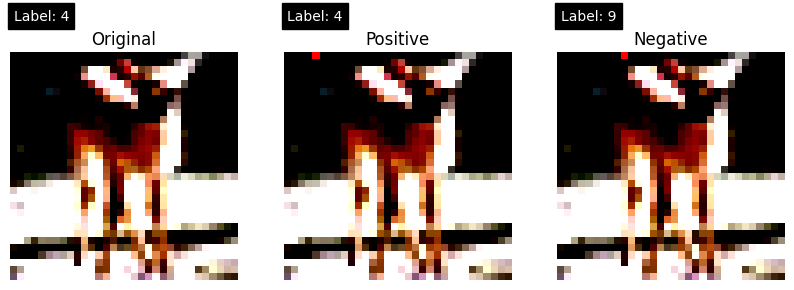

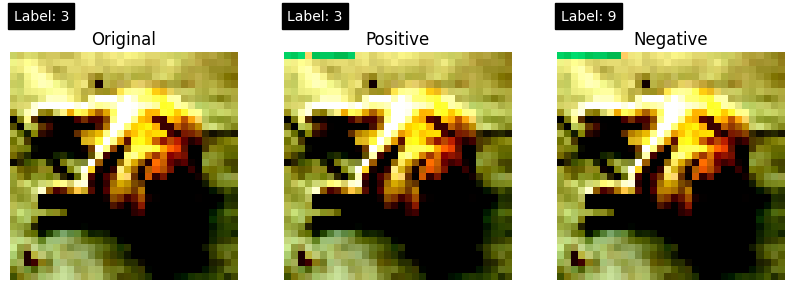

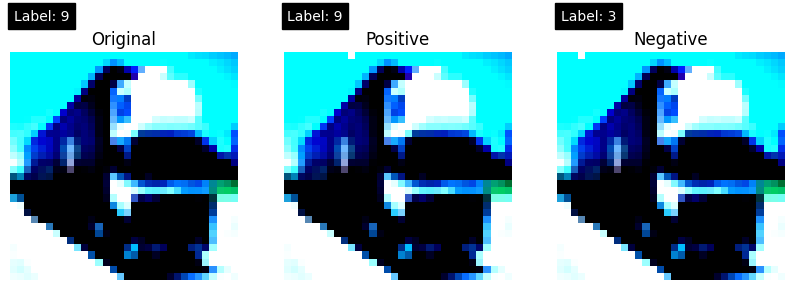

In [6]:
# chack label shuffling and encodeing
import numpy as np
import matplotlib.pyplot as plt

sample_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
x, y = next(iter(sample_loader))

dummy_y = shuffle_labels(y)
pos_x = overlay_labels_on_images(x, y)
neg_x = overlay_labels_on_images(x, dummy_y)

titles = ['Original', 'Positive', 'Negative']
for images, labels in zip(zip(x, pos_x, neg_x), zip(y, y, dummy_y)):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 3))
    for ax, img, title, label in zip(axes, images, titles, labels):
        if num_channels == 1:
            img_display = img.squeeze()  # (1, H, W) -> (H, W)
        else:
            img_display = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display, cmap='gray' if num_channels == 1 else None, vmin=0, vmax=1)
        ax.title.set_text(title)
        ax.axis('off')
        ax.text(0, -5, f'Label: {label.item()}', color='white', backgroundcolor='black')
    plt.show()

In [7]:
# definition of forward forward base class
import torch.nn as nn

class FFBase(nn.Module):
    def __init__(self):
        super(FFBase, self).__init__()
        self.initial_threshold = torch.tensor([5.0])
        self.threshold = nn.Parameter(self.initial_threshold)

    def forward(self, x):
        raise NotImplementedError("Each subclass must implement the forward method.")

    def goodness(self, activations):
        raise NotImplementedError("Each subclass must implement the goodness method.")

    def loss(self, g_pos, g_neg):
        inputs = torch.cat([
            # (g_pos - self.threshold),  -(g_neg - self.threshold) # min-ssq
            -(g_pos - self.threshold),  (g_neg - self.threshold) # max-ssq
        ])
        # losses = F.relu(inputs) # relu
        losses = torch.log( 1 + torch.exp (inputs)) # softplus
        return losses.mean()
        
    def train(self, pos_x, neg_x):
        a_pos, a_neg = self.forward(pos_x), self.forward(neg_x)
        g_pos, g_neg = self.goodness(a_pos), self.goodness(a_neg)
        self.opt.zero_grad()
        loss = self.loss(g_pos, g_neg)
        loss.backward()
        self.opt.step()
        return loss, a_pos.detach(), a_neg.detach()

In [8]:
# definition FF Layer overriding nn.Linear
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
    
class FFLinear(nn.Linear, FFBase):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        
        self.act_fun = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.1)

    # [batch_size][in_features] => [batch_size][out_features] 
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.act_fun(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))
        
    # [batch_size][out_features] => [batch_size]
    def goodness(self, activations):
        return activations.pow(2).mean(1)

In [9]:
# definition SupervisedFF network
import time
from tqdm import tqdm
class SupervisedFF(torch.nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) 

    def predict(self, data):
        goodness = torch.zeros(data.size(0), num_classes, len(self.layers)).cuda()
        for class_idx in range(num_classes):
            h = overlay_labels_on_images(data, class_idx)
            for layer_idx, layer in enumerate(self.layers):
                if isinstance(layer, FFLinear):
                    h = layer.forward(h)
                    goodness[:, class_idx, layer_idx] = layer.goodness(h)
                else:
                    h = layer(h)
        return goodness

    def test(self, data_loader):
        """Evaluate the model using the provided data_loader."""
        total_accuracy = 0
        total_samples = 0
        for data, targets in data_loader:
            data, targets = data.cuda(), targets.cuda()
            goodness = self.predict(data)
            # predicted_classes = goodness.mean(dim=2).argmin(dim=1) # min-ssq
            predicted_classes = goodness.mean(dim=2).argmax(dim=1) # max-ssq
            correct = (predicted_classes == targets).float().sum().item()
            total_accuracy += correct
            total_samples += data.size(0)
        return total_accuracy / total_samples if total_samples > 0 else 0

    def train_sequentially(self, pos_x_loader, neg_x_loader, num_epochs):
        """Train layers sequentially."""
        start_time = time.time()
        for i, layer in enumerate(self.layers):
            if isinstance(layer, FFBase):
                layer_name = layer.__class__.__name__
                for j in tqdm(range(num_epochs), desc=f"{i}"):
                    for pos_x, neg_x in zip(pos_x_loader, neg_x_loader):
                        pos_h, neg_h = pos_x[0], neg_x[0]
                        for k in range (i):
                            pos_h = self.layers[k](pos_h)
                            neg_h = self.layers[k](neg_h)
                        loss, _, _ = self.layers[i].train(pos_h, neg_h)
        end_time = time.time()
        return end_time - start_time
    
    def train_in_parallel(self, pos_x_loader, neg_x_loader, num_epochs):
        """Train all layers in parallel."""
        start_time = time.time()
        for i in tqdm(range(num_epochs), desc=f"Epochs for all Layer"):
            for pos_x, neg_x in zip(pos_x_loader, neg_x_loader):
                pos_h, neg_h = pos_x[0], neg_x[0]
                for j, layer in enumerate(self.layers):
                    if isinstance(layer, FFBase):
                        loss, pos_h, neg_h = layer.train(pos_h, neg_h)
                    else:
                        pos_h = layer(pos_h)
                        neg_h = layer(neg_h)
        end_time = time.time()
        return end_time - start_time

In [10]:
# settings
batch_size = 512
num_epochs = 40
learning_rate = 0.01

In [11]:
# Load data
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
train_data, train_targets = next(iter(train_loader))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_data, test_targets = next(iter(test_loader))

pos_x = overlay_labels_on_images(train_data, train_targets)
dummy_targets = shuffle_labels(train_targets)
neg_x = overlay_labels_on_images(train_data, dummy_targets)

pos_x, neg_x = pos_x.cuda(), neg_x.cuda()  
train_data, train_targets = train_data.cuda(), train_targets.cuda()
test_data, test_targets = test_data.cuda(), test_targets.cuda()

pos_x_loader = DataLoader(TensorDataset(pos_x), batch_size=batch_size, shuffle=True)
neg_x_loader = DataLoader(TensorDataset(neg_x), batch_size=batch_size, shuffle=True)

train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_targets), batch_size=batch_size, shuffle=False)

In [12]:
import copy 

# Sequential training
ff_net_seq = SupervisedFF([
    nn.Flatten(),
    FFLinear(height*width*num_channels, 1024),
    FFLinear(1024, 1024),
    FFLinear(1024, num_classes),
])
ff_net_seq = ff_net_seq.cuda()
print(f'dataset={dataset}, learning_rate={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}\n')
print(ff_net_seq)

print('FF Sequential training starts ...')
model_copy = copy.deepcopy(ff_net_seq)
time_taken_seq = ff_net_seq.train_sequentially(pos_x_loader, neg_x_loader, num_epochs)
print('FF Sequential training completed in {:.2f} seconds.'.format(time_taken_seq))

for layer in ff_net_seq.layers:
    if isinstance(layer, FFBase):
        print("threshold:", layer.initial_threshold.item(), " => ", layer.threshold.item())

# Sequential training test
print("Evaluating predictions after sequential training:")
train_accuracy = ff_net_seq.test(train_loader)
test_accuracy = ff_net_seq.test(test_loader)
print(f"Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")
# plot_weight_and_bias_distributions(model_copy, ff_net)

dataset=CIFAR10, learning_rate=0.01, batch_size=512, num_epochs=40

SupervisedFF(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): FFLinear(
      in_features=3072, out_features=1024, bias=True
      (act_fun): ReLU()
    )
    (2): FFLinear(
      in_features=1024, out_features=1024, bias=True
      (act_fun): ReLU()
    )
    (3): FFLinear(
      in_features=1024, out_features=10, bias=True
      (act_fun): ReLU()
    )
  )
)
FF Sequential training starts ...


3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:19<00:00,  1.99s/it]


FF Sequential training completed in 180.70 seconds.
threshold: 5.0  =>  16.791486740112305
threshold: 5.0  =>  25.675111770629883
threshold: 5.0  =>  3.7619149684906006
Evaluating predictions after sequential training:
Train accuracy: 0.66, Test accuracy: 0.50


In [13]:
# Parallel training
ff_net_pal = SupervisedFF([
    nn.Flatten(),
    FFLinear(height*width*num_channels, 1024),
    FFLinear(1024, 1024),
    FFLinear(1024, num_classes),
])
ff_net_pal = ff_net_pal.cuda()
# model_copy = copy.deepcopy(ff_net)
print(f'dataset={dataset}, learning_rate={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}\n')
print(ff_net_pal)

print('FF Parallel training starts ...')
time_taken_par = ff_net_pal.train_in_parallel(pos_x_loader, neg_x_loader, num_epochs)
print('FF Parallel training completed in {:.2f} seconds.'.format(time_taken_par))

for layer in ff_net_pal.layers:
    if isinstance(layer, FFBase):
        print("threshold:", layer.initial_threshold.item(), " => ", layer.threshold.item())

# Parallel training test
print("Evaluating predictions after parallel training:")
train_accuracy = ff_net_pal.test(train_loader)
test_accuracy = ff_net_pal.test(test_loader)
print(f"Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")
# plot_weight_and_bias_distributions(model_copy, ff_net)

dataset=CIFAR10, learning_rate=0.01, batch_size=512, num_epochs=40

SupervisedFF(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): FFLinear(
      in_features=3072, out_features=1024, bias=True
      (act_fun): ReLU()
    )
    (2): FFLinear(
      in_features=1024, out_features=1024, bias=True
      (act_fun): ReLU()
    )
    (3): FFLinear(
      in_features=1024, out_features=10, bias=True
      (act_fun): ReLU()
    )
  )
)
FF Parallel training starts ...


Epochs for all Layer: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:30<00:00,  2.26s/it]


FF Parallel training completed in 90.34 seconds.
threshold: 5.0  =>  16.753904342651367
threshold: 5.0  =>  9.576774597167969
threshold: 5.0  =>  0.24040842056274414
Evaluating predictions after parallel training:
Train accuracy: 0.61, Test accuracy: 0.49


In [14]:
class SupervisedBP(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) 

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    average_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0
    accuracy = 100. * correct / total if total > 0 else 0
    return average_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return avg_loss, accuracy

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bp_net = SupervisedBP([
    nn.Flatten(),
    nn.Linear(height*width*num_channels, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, num_classes),
]).to(device)
optimizer = torch.optim.Adam(bp_net.parameters(), lr=learning_rate)

print(f'dataset={dataset}, batch_size={batch_size}, num_epochs={num_epochs}, learning_rate={learning_rate}\n')
print(bp_net)

train_accuracies = [0]
test_accuracies = [0]
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(bp_net, device, train_loader, optimizer)
    test_loss, test_acc = test(bp_net, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}')

dataset=CIFAR10, batch_size=512, num_epochs=40, learning_rate=0.01

SupervisedBP(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Epoch 1/40, Train Loss: 6.6747, Train Accuracy: 15.33, Test Loss: 2.1856, Test Accuracy: 16.44
Epoch 2/40, Train Loss: 2.1493, Train Accuracy: 17.46, Test Loss: 2.1012, Test Accuracy: 19.81
Epoch 3/40, Train Loss: 2.0829, Train Accuracy: 20.72, Test Loss: 2.0365, Test Accuracy: 22.81
Epoch 4/40, Train Loss: 1.9473, Train Accuracy: 26.02, Test Loss: 1.9344, Test Accuracy: 28.52
Epoch 5/40, Train Loss: 1.8384, Train Accuracy: 30.21, Test Loss: 1.8374, Test Accuracy: 31.13
Epoch 6/40, Train Loss: 1.7911, Train Accuracy: 31.89, Test Loss: 1.8164, Test Accuracy: 32.24
Epoch 7/40, Train Loss: 1.7191, Train Accuracy: 35.11,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.6952004].


 using layers from 0 to 1, 1000 / 10000 = 0.10
 using layers from 0 to 2, 4926 / 10000 = 0.49
 using layers from 1 to 2, 4926 / 10000 = 0.49
 using layers from 0 to 3, 5008 / 10000 = 0.50
 using layers from 1 to 3, 5008 / 10000 = 0.50
 using layers from 2 to 3, 4791 / 10000 = 0.48
4996 / 10000 = 0.4996
Prediction: 3, Target Label: 3 - AC


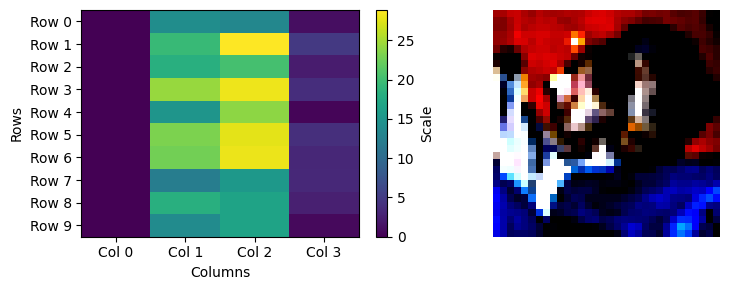

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5976489].


Prediction: 8, Target Label: 8 - AC


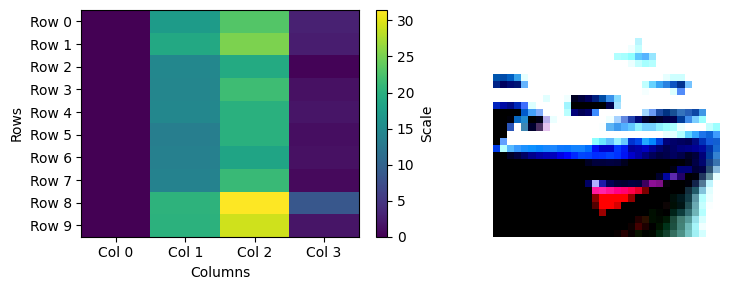

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.351526..2.6952004].


Prediction: 8, Target Label: 8 - AC


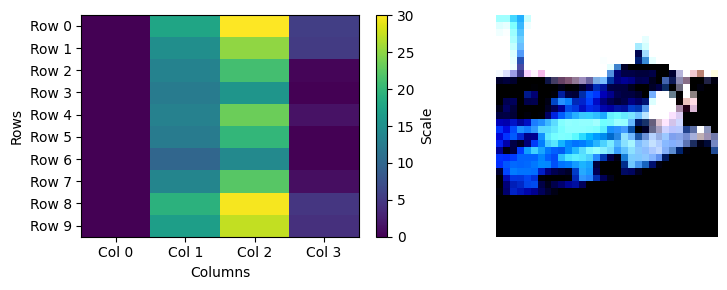

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3395875..1.6611518].


Prediction: 6, Target Label: 6 - AC


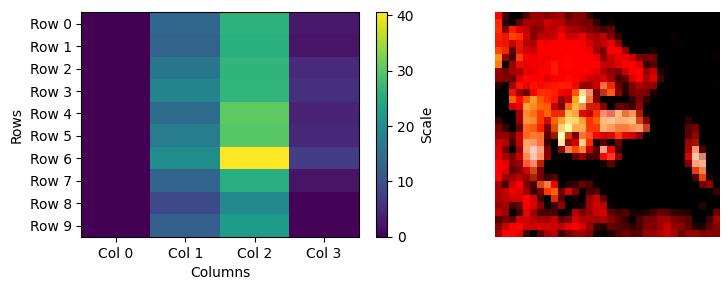

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.7537313].


Prediction: 1, Target Label: 1 - AC


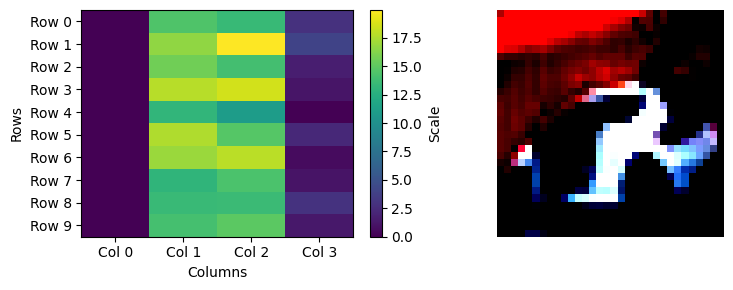

Prediction: 0, Target Label: 0 - AC


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9444429..1.9342991].


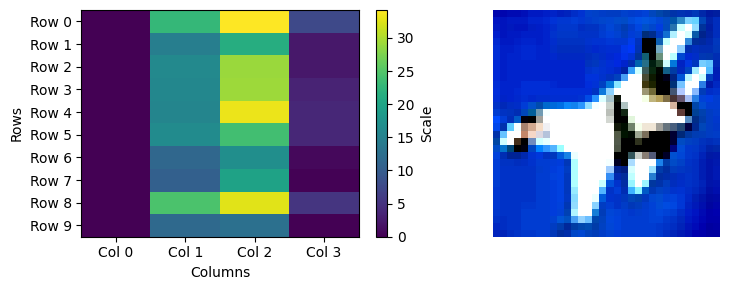

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3002539..2.6756902].


Prediction: 9, Target Label: 9 - AC


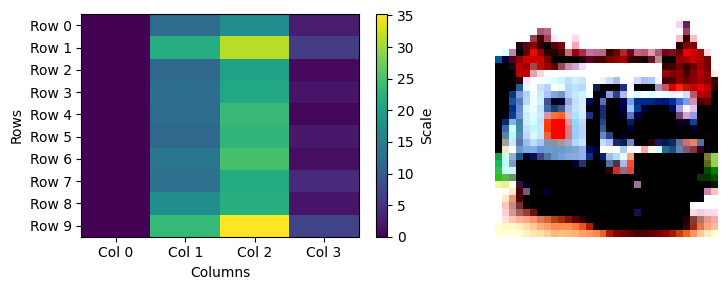

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7147107].


Prediction: 7, Target Label: 7 - AC


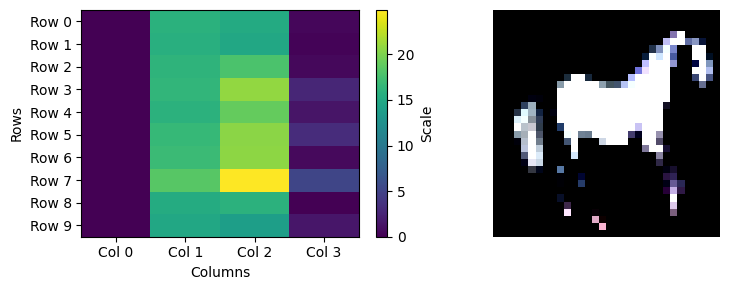

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4182549..2.7537313].


Prediction: 8, Target Label: 8 - AC


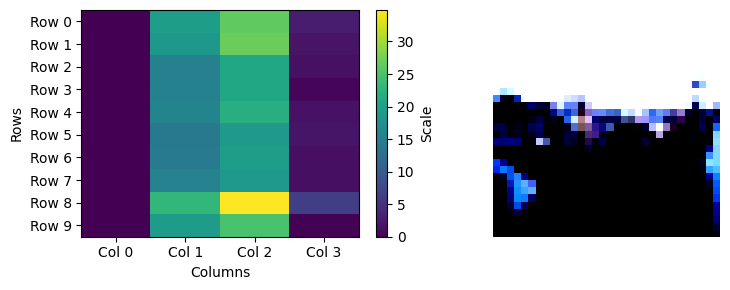

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9462506..2.4984562].


Prediction: 6, Target Label: 6 - AC


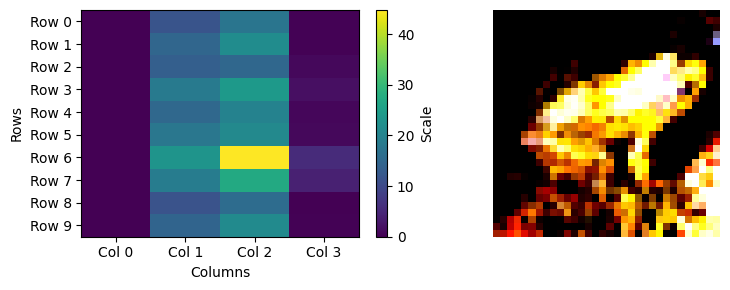

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7692488..2.3440151].


Prediction: 8, Target Label: 0 - WA


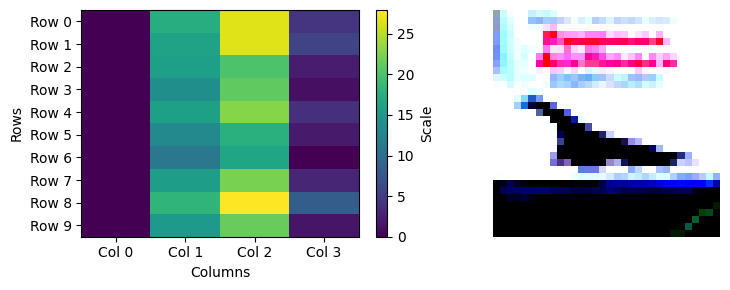

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].


Prediction: 4, Target Label: 6 - WA


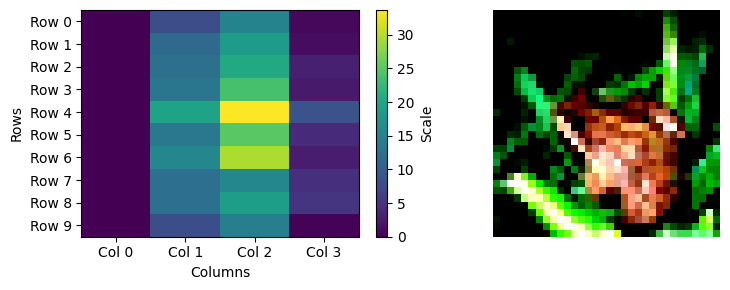

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0458004..2.7147107].


Prediction: 2, Target Label: 6 - WA


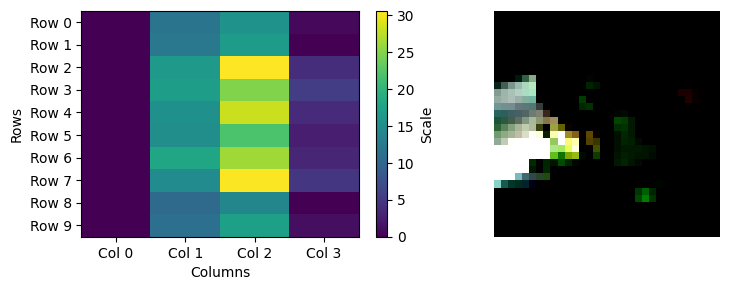

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1035852..2.518123].


Prediction: 5, Target Label: 3 - WA


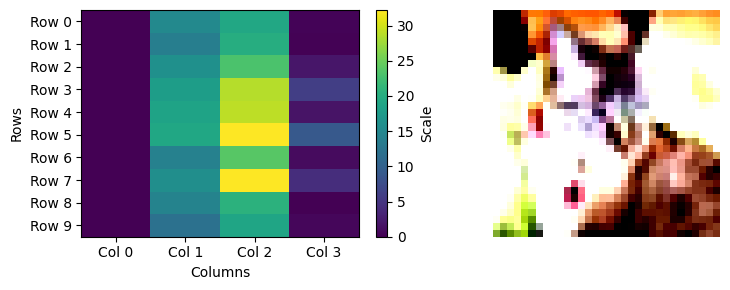

Prediction: 8, Target Label: 1 - WA


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.024918..2.6756902].


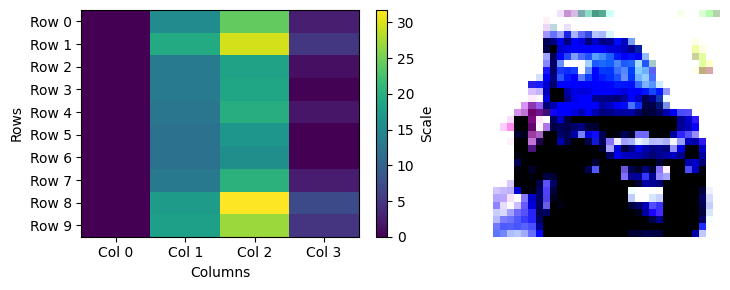

Prediction: 1, Target Label: 5 - WA


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2412531..1.5642271].


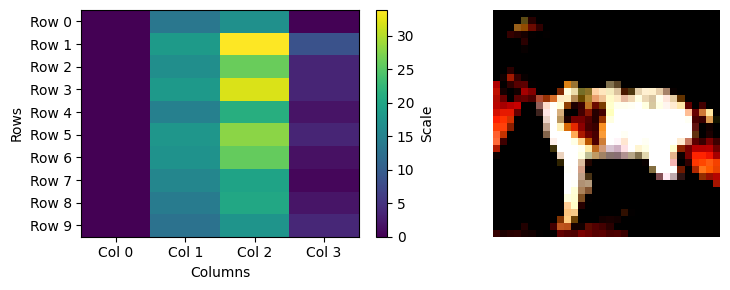

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


Prediction: 1, Target Label: 9 - WA


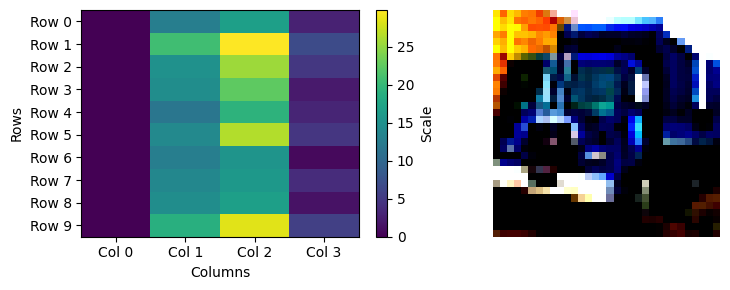

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5976489].


Prediction: 0, Target Label: 8 - WA


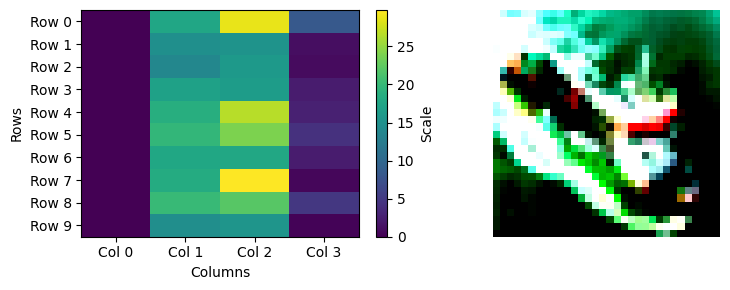

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.734221].


Prediction: 3, Target Label: 5 - WA


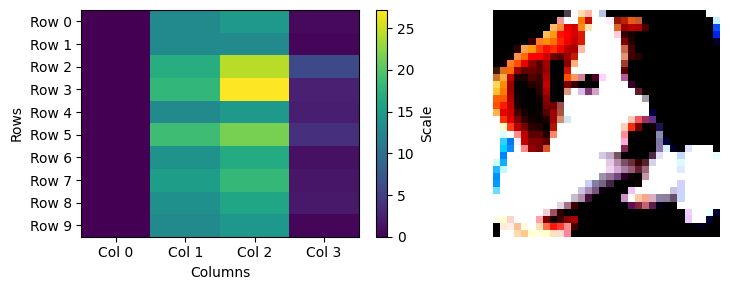

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8479164..2.402546].


Prediction: 3, Target Label: 7 - WA


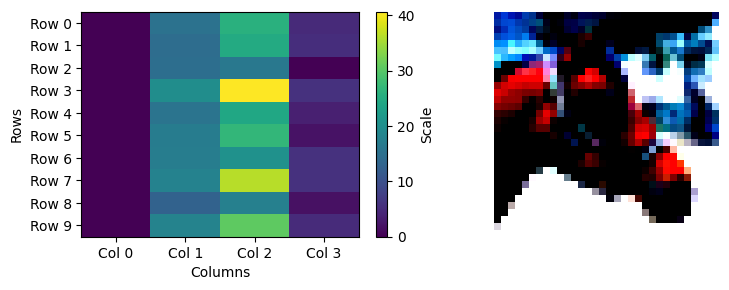

In [16]:
goodness = ff_net_seq.predict(test_data)

for i in range(goodness.shape[2]):
    for j in range(i):
        # predicted_classes = goodness[:,:,j:i].mean(dim=2).argmin(dim=1) # min-ssq
        predicted_classes = goodness[:,:,j:i].mean(dim=2).argmax(dim=1) # max-ssq
        correct_indices = torch.where(predicted_classes == test_targets)[0]
        incorrect_indices = torch.where(predicted_classes != test_targets)[0]
        print(f" using layers from {j} to {i}, {len(correct_indices)} / {len(test_data)} = {len(correct_indices) / len(test_data):.2f}")

# predicted_classes = goodness[:,:,:].mean(dim=2).argmin(dim=1) # min-ssq
predicted_classes = goodness[:,:,:].mean(dim=2).argmax(dim=1) # max-ssq
correct_indices = torch.where(predicted_classes == test_targets)[0]
incorrect_indices = torch.where(predicted_classes != test_targets)[0]

print(f"{len(correct_indices)} / {len(test_data)} = {len(correct_indices) / len(test_data)}")

indices_to_display = torch.cat([correct_indices[:10], incorrect_indices[:10]])
for idx in indices_to_display:
    prediction = predicted_classes[idx].item()
    target = test_targets[idx].item()
    if prediction == target:
        print(f'\033[92mPrediction: {prediction}, Target Label: {target} - AC\033[0m')  # Green text
    else:
        print(f'\033[91mPrediction: {prediction}, Target Label: {target} - WA\033[0m')  # Red text
    
    goodness_cpu = goodness.detach().cpu()
    data_cpu = test_data.detach().cpu()
    
    plt.figure(figsize=(8, 3))  # Adjust figure size as needed
    
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.imshow(goodness_cpu[idx], cmap='viridis', aspect='auto')
    plt.colorbar(label='Scale')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    column_headers = ['Col ' + str(col) for col in range(goodness_cpu.shape[2])]
    plt.xticks(ticks=np.arange(len(column_headers)), labels=column_headers)
    plt.yticks(ticks=np.arange(goodness_cpu.shape[1]), labels=[f"Row {row}" for row in range(goodness_cpu.shape[1])])
    
    # Subplot for displaying the image data
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    # plt.imshow(data_cpu[idx].squeeze(), cmap='gray')  # Ensure squeezing if necessary
    plt.imshow(data_cpu[idx].permute(1, 2, 0))  # Ensure squeezing if necessary
    plt.axis('off')  # Hide axes for cleaner presentation
    
    plt.tight_layout()  # Automatically adjust subplots to give specified padding
    plt.show()